# Demo of INR with Complex-Valued Output

Zach Stoebner  

INRs typically have real-valued coordinates as inputs but potentially complex-valued outputs. What is the best way to handle complex-valued outputs? 

In [1]:
import os
from os import path
from typing import Optional, Tuple, Union, List
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
from copy import deepcopy
from IPython.display import Image, display

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import lightning.pytorch as pl
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger

import inrlib

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
torch.set_float32_matmul_precision('medium')

%matplotlib inline

## Data

In [2]:
res = 96
train_dataset = inrlib.MRI3DDataset(RES=res,  # resolution of the image
                            train=True, # use training set of coords
                            shepp_or_atlas='shepp', # use shepp logan phantom
                            complex=True, # use complex data
                            )

train_dataset.change_stage(train=True)
val_dataset = deepcopy(train_dataset)
val_dataset.change_stage(train=False)

In [3]:
# flattened coordinate array and unique x coorindates

coords = train_dataset.x_data
coords.shape, np.unique(coords[..., 0])

((884736, 3),
 array([0.        , 0.01041667, 0.02083333, 0.03125   , 0.04166667,
        0.05208333, 0.0625    , 0.07291667, 0.08333333, 0.09375   ,
        0.10416667, 0.11458333, 0.125     , 0.13541667, 0.14583333,
        0.15625   , 0.16666667, 0.17708333, 0.1875    , 0.19791667,
        0.20833333, 0.21875   , 0.22916667, 0.23958333, 0.25      ,
        0.26041667, 0.27083333, 0.28125   , 0.29166667, 0.30208333,
        0.3125    , 0.32291667, 0.33333333, 0.34375   , 0.35416667,
        0.36458333, 0.375     , 0.38541667, 0.39583333, 0.40625   ,
        0.41666667, 0.42708333, 0.4375    , 0.44791667, 0.45833333,
        0.46875   , 0.47916667, 0.48958333, 0.5       , 0.51041667,
        0.52083333, 0.53125   , 0.54166667, 0.55208333, 0.5625    ,
        0.57291667, 0.58333333, 0.59375   , 0.60416667, 0.61458333,
        0.625     , 0.63541667, 0.64583333, 0.65625   , 0.66666667,
        0.67708333, 0.6875    , 0.69791667, 0.70833333, 0.71875   ,
        0.72916667, 0.73958333, 0.

<class 'numpy.ndarray'> complex128


(-0.5, 95.5, 95.5, -0.5)

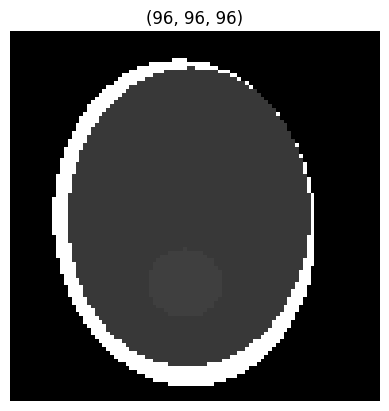

In [4]:
image = train_dataset.image
print(type(image), image.dtype)

plt.imshow(np.abs(image[..., res//2]), cmap='gray')
plt.title(f'{image.shape}')
plt.axis('off')

In [5]:
datamodule = inrlib.GenericDataModule(batch_size=None,
                                   num_workers=8, 
                                   use_worker_init_fn=True,
                                   train=train_dataset, 
                                   val=val_dataset, # not necessary
                                   )

## Loss

In [6]:
# define loss subclass

from typing import Mapping


class ComplexINRLoss(inrlib.ABCLoss):
    def set_params(self, *args, **kwargs):
        '''
        Set additional optimization parameters for loss, i.e., clean reconstruction
        '''
        return
    
    def reconstruct_params(self, image_shape, outputs, **other) -> Mapping[str, np.ndarray]:
        '''
        If added additional parameters, reconstruct them here 
        '''
        return {**other}
    
    def prepare_input(self,  x: torch.Tensor, y: torch.Tensor, **other) -> Mapping[str, torch.Tensor]:
        xi = x.clone()
        yi = inrlib.make_complex(y)
        yi = inrlib.make_real(yi)
        return {'x': xi, 'y': yi, **other}
    
    def prepare_output(self,  y_hat: torch.Tensor, y: torch.Tensor, **other) -> Mapping[str, torch.Tensor]:
        return {'pred': torch.squeeze(y_hat), 
                'target': torch.squeeze(y), 
                **other}

### Constraints

In [7]:
constr = inrlib.ComplexImaginaryConstraint()

### Regularization

In [8]:
reg = inrlib.L1Regularizer(dim=None, 
                        weight=1e-4, 
                        constraints=[constr]
                        )

In [9]:
# compose loss function

loss_fn = ComplexINRLoss('complex_mse', # loss type can be anything
                    regularizers=[reg], 
                    fncs=[inrlib.MSELoss()],
                    )

## Model

In [10]:
posenc = inrlib.GaussianPosEnc(d_input=3, # dimensionality of input ie (x,y,z)
                            embed_sz=256, # number of features to lift to
                            scale=2. # scaling factor of the gaussian
                            )

In [11]:
MLP = inrlib.NeuralImplicitMLP(
    lr=1e-3, # learning rate
    posenc=posenc, # positional encoding
    n_features=256, # input dimension
    n_layers=16, # network depth
    n_output=2,  # complex output
    
    ###
    loss_fn=loss_fn, # loss function
    act_fn=nn.LeakyReLU(), # activation function
    norm_fn=nn.Identity(), # normalization function
    output_fn=nn.Identity(), # no output activation -> unbounded output
    ###
    
    optimizer=torch.optim.Adam,
    metrics=[inrlib.NRMSELoss()] # metrics to track besides loss, min, max
    )

## Logging

In [12]:
phase_transf = inrlib.PhaseTransform(cmap='gray', vmin=-3.14, vmax=3.14)
mag_transf = inrlib.MagnitudeTransform(cmap='gray')
view_transfs = [phase_transf, mag_transf]

img_logger = inrlib.NeuralImplicitImageLogger(view_transforms=view_transfs, # callables to transform output for viewing, i.e., phase and magnitude for complex-valued images
                                        save_freq=10, # how often to save images
                                        best_only=True, # only save best images
                                       )

## Training

In [13]:
logger = CSVLogger(save_dir='logs/shepp', 
                   name='complex_shepp_demo', 
                   version=1) # not needed, but useful for logging
bar = TQDMProgressBar(refresh_rate=1000)

trainer = pl.Trainer(max_epochs=10, 
                     log_every_n_steps=1, 
                     benchmark=True,
                     accumulate_grad_batches=2,
                     logger=logger,
                     callbacks=[img_logger, bar], 
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model=MLP, datamodule=datamodule)

/home/zstoebs/research/inrlib/inrlib/utils/visualization.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  img = (img * 255).astype(np.uint8)
/home/zstoebs/research/inrlib/inrlib/utils/visualization.py:28: RuntimeWarning: invalid value encountered in cast
  img = (img * 255).astype(np.uint8)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name       | Type           | Params
----------------------------------------------
0 | posenc     | GaussianPosEnc | 1.0 K 
1 | loss_fn    | ComplexINRLoss | 0     
2 | act_fn     | LeakyReLU      | 0     
3 | norm_fn    | Identity       | 0     
4 | output_fn  | Identity       | 0     
5 | base_model | Sequential     | 1.1 M 
----------------------------------------------
1.1 M     Trainable params
1.0 K     Non-trainable params
1.1 M     Total params
4.216     Total estimated model params size (MB)
/home/zstoebs/anaconda3/envs/nerf/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: E

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/zstoebs/anaconda3/envs/nerf/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


If we run complex floats are not implemented by PyTorch on GPU... :( So we have to keep complex outputs as 2-channel real until after backpropagation. 